In [45]:
from __future__ import annotations

In [46]:
import warnings

warnings.filterwarnings("ignore") 

In [47]:
import sys
sys.path.append("../")

import os
from joblib import dump, load

from C_scrub.d_DASK_CUDA_RAPIDS_data_engineering import scrub_feature_engineering

from collections.abc import Iterator
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt

import xgboost
from cuml.metrics.accuracy import accuracy_score
import optuna

import dask_cudf
import dask
import dask.dataframe as dd
import distributed
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

# System set-up

In [48]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'A_data')
RESOURCES_DIR = os.path.join(BASE_DIR, 'B_resources', 'd_DASK_CUDA_RAPIDS')

In [49]:
dask.config.set({"array.backend": "cupy"})
dask.config.set({"dataframe.backend": "cudf"})

In [50]:
if __name__ == "__main__":
    def get_cluster():
        cluster = LocalCUDACluster(
            device_memory_limit='10GB',
            jit_unspill=True
        )
        client = Client(cluster)
        return client

    client = get_cluster()
    n_workers = len(client.scheduler_info()["workers"])

In [51]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 251.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36259,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 251.77 GiB
Comm: tcp://127.0.0.1:36611,Total threads: 1
Dashboard: http://127.0.0.1:33693/status,Memory: 251.77 GiB
Nanny: tcp://127.0.0.1:37357,


In [52]:
import time
from contextlib import contextmanager

# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

# Collect data

In [53]:
data_compet = dd.read_csv(os.path.join(DATA_DIR, "train.csv")).set_index('id')
data_orig = dd.read_csv(os.path.join(DATA_DIR, 'horse.csv'))  # Include public data

data_orig['id'] = data_orig.index + data_compet.index.max() + 1
data_orig = data_orig.set_index('id')

data = dd.concat([data_compet, data_orig])
data = data.dropna(subset=['outcome'])
data = data.drop_duplicates()

del data_compet, data_orig

# Prepare data

In [54]:
data = scrub_feature_engineering(data, train=True)
data = dask_cudf.from_cudf(data, npartitions=2)

# Parameters definition

In [55]:
random_seed = 9421

# test split size
split_size = 0.2

#Number of cross-validation folds
n_folds = 4

# number of iteration for RamdomizedSearchCV
XGB_grid_n_iter_search = 100

# Number of parallel optuna jobs to run
N_JOBS = 1

# Number of converging serial trials to run in each job.
N_TRIALS = 10

# The number of training exercises that will be run in total is
# N_JOBS * N_TRIALS * n_folds

# Number of parallel training exercises
N_PARALLEL = 2

# Dask worker instance type and number
N_WORKERS = n_workers

# Split data

In [56]:
train_data, test_data = data.random_split([1- split_size, split_size], shuffle=True, random_state=random_seed)

In [57]:
print(train_data['outcome'].value_counts().compute())

0    618
2    387
1    226
Name: outcome, dtype: int64


In [58]:
print(test_data['outcome'].value_counts().compute())

0    134
2    100
1     69
Name: outcome, dtype: int64


In [59]:
train_data.persist()

if "train_data" in client.datasets:
    client.unpublish_dataset("train_data")
client.publish_dataset(train_data=train_data)

train_data.head()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,numLesions,surgery_0.0,age_0.0,...,lesionCode_1.0,lesionCode_2.0,lesionCode_3.0,lesionCode_5.0,lesionCode_6.0,lesionCode_7.0,lesionCode_8.0,lesionCode_9.0,lesionCode_10.0,outcome
id,,,,,,,,,,,,,,,,,,,,,
591,0.920228,-0.369045,-0.472464,-0.785785,-0.573249,-0.575263,0.386810,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,3.060207,-0.2,0
638,-0.257444,-0.545559,-0.568910,0.058562,-0.573249,-0.496918,-0.858120,0.264269,1.511554,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,3.060207,-0.2,1
703,-1.304263,-0.203076,-1.006999,1.465808,-0.096439,-0.377755,1.731854,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,1.866917,-0.185445,-0.159377,-0.355366,-0.326775,-0.2,0
583,-2.220231,-0.046462,-0.207439,-1.348683,1.524715,-0.575263,0.257345,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,-0.326775,-0.2,2
251,0.004261,0.504303,-0.568910,0.621461,-0.477887,-0.447669,1.302771,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,6.274426,-0.355366,-0.326775,-0.2,0


# Train model

In [60]:
# Here we subset data for cross-validation
def make_cv_splits(ddf: dd.DataFrame, n_folds: int = 5) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True, random_state=random_seed)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test = splits[i]
        yield dd.concat(train), test

In [61]:
def train_once(
        train: dd.DataFrame,
        test: dd.DataFrame,
        sem: distributed.Semaphore,
        study_params: dict[str, float],
):
    distributed.secede()
    # Block until there are less than N_PARALLEL train_once critical sections running
    with sem:
        y_train = train["outcome"]
        X_train = train.drop(columns=["outcome"])
        y_test = test["outcome"]
        X_test = test.drop(columns=["outcome"])

        d_train = xgboost.dask.DaskQuantileDMatrix(None, X_train, y_train)
        
        # This has its own internal semaphore with a limit of 1
        model = xgboost.dask.train(
            None,
            {'objective':'multi:softmax',
             'num_class':3,
             "eval_metric": "mlogloss",
             "tree_method": "gpu_hist",
             'predictor':'gpu_predictor',
             **study_params},
            d_train,
            num_boost_round=XGB_grid_n_iter_search,
            evals=[(d_train, "train")],
        )
        predictions = xgboost.dask.predict(None, model, X_test)
        score = accuracy_score(y_test.astype("float32"), predictions, convert_dtype=True)
        return score

In [62]:
def train_model(
        ddf_name: str,
        n_folds: int,
        sem: distributed.Semaphore,
        study_params: dict[str, float],
):
    client = distributed.get_client()
    ddf = client.get_dataset(ddf_name)

    futures = [
        client.submit(train_once, train, test, sem, study_params, pure=False)
        for train, test in make_cv_splits(ddf, n_folds)
    ]

    try:
        distributed.secede()
    except KeyError:
        # Already seceded in a previous iteration of study.optimize()
        pass

    scores = client.gather(futures)
    return sum(scores) / len(scores)

In [63]:
def objective(trial, ddf_name: str, n_folds: int, sem: distributed.Semaphore) -> float:
    study_params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.2, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.3, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "max_leaves": trial.suggest_int("max_leaves", 0, 10)
    }
    return train_model(ddf_name, n_folds, sem, study_params)

In [64]:
total_studies = N_JOBS * N_TRIALS * n_folds
print(f"Total studies: {total_studies}")

# Create a single study and run some trials
start = datetime.now()
storage = optuna.integration.DaskStorage()
study = optuna.create_study(storage=storage, study_name="dask_cuml_optuna-HPO", direction="maximize")

# Run N_JOBS in parallel
# each job will run N_TRIALS converging trials in series
# each trial will start n_folds training exercises in parallel
# but only up to N_PARALLEL training exercise will actually submit
# tasks to the scheduler at the same time.

# In pure optuna, we would have used
# study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS)
sem = distributed.Semaphore(N_PARALLEL)
futures = [
    client.submit(
        study.optimize,
        partial(objective, ddf_name="train_data", n_folds=n_folds, sem=sem),
        n_trials=N_TRIALS,
        pure=False,
    )
    for _ in range(N_JOBS)
]
client.gather(futures)

print(f"Total time:  {datetime.now() - start}")

[I 2023-11-01 12:22:55,618] A new study created in memory with name: dask_cuml_optuna-HPO


Total studies: 40


/home/jgsolar/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  return pickle.loads(x)
[12:23:02] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.96292
[1]	train-mlogloss:0.88039
[2]	train-mlogloss:0.83153
[3]	train-mlogloss:0.80116
[4]	train-mlogloss:0.76657
[5]	train-mlogloss:0.74021
[6]	train-mlogloss:0.71525
[7]	train-mlogloss:0.69564
[8]	train-mlogloss:0.68002
[9]	train-mlogloss:0.66608
[10]	train-mlogloss:0.65672
[11]	train-mlogloss:0.64594
[12]	train-mlogloss:0.63876
[13]	train-mlogloss:0.63213
[14]	train-mlogloss:0.62662
[15]	train-mlogloss:0.61995
[16]	train-mlogloss:0.61262
[17]	train-mlogloss:0.60561
[18]	train-mlogloss:0.59962
[19]	train-mlogloss:0.59454
[20]	train-mlogloss:0.58889
[21]	train-mlogloss:0.58440
[22]	train-mlogloss:0.57913
[23]	train-mlogloss:0.57189
[24]	train-mlogloss:0.56735
[25]	train-mlogloss:0.56305
[26]	train-mlogloss:0.55921
[27]	train-mlogloss:0.55632
[28]	train-mlogloss:0.55177
[29]	train-mlogloss:0.54805
[30]	train-mlogloss:0.54507
[31]	train-mlogloss:0.54149
[32]	train-mlogloss:0.53822
[33]	train-mlogloss:0.53547
[34]	train-mlogloss:0.53255
[35]	train-mlogloss:0.52942
[3

[12:23:04] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.95513
[1]	train-mlogloss:0.86670
[2]	train-mlogloss:0.81083
[3]	train-mlogloss:0.77284
[4]	train-mlogloss:0.74951
[5]	train-mlogloss:0.72163
[6]	train-mlogloss:0.70127
[7]	train-mlogloss:0.68415
[8]	train-mlogloss:0.66865
[9]	train-mlogloss:0.65335
[10]	train-mlogloss:0.64363
[11]	train-mlogloss:0.63376
[12]	train-mlogloss:0.62709
[13]	train-mlogloss:0.62018
[14]	train-mlogloss:0.61459
[15]	train-mlogloss:0.60914
[16]	train-mlogloss:0.60008
[17]	train-mlogloss:0.59393
[18]	train-mlogloss:0.58643
[19]	train-mlogloss:0.58151
[20]	train-mlogloss:0.57695
[21]	train-mlogloss:0.57272
[22]	train-mlogloss:0.56794
[23]	train-mlogloss:0.56367
[24]	train-mlogloss:0.56000
[25]	train-mlogloss:0.55678
[26]	train-mlogloss:0.55314
[27]	train-mlogloss:0.54912
[28]	train-mlogloss:0.54548
[29]	train-mlogloss:0.54287
[30]	train-mlogloss:0.53959
[31]	train-mlogloss:0.53580
[32]	train-mlogloss:0.53279
[33]	train-mlogloss:0.52943
[34]	train-mlogloss:0.52661
[35]	train-mlogloss:0.52414
[3

[12:23:11] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.97028
[1]	train-mlogloss:0.88570
[2]	train-mlogloss:0.83083
[3]	train-mlogloss:0.79400
[4]	train-mlogloss:0.77206
[5]	train-mlogloss:0.74789
[6]	train-mlogloss:0.72266
[7]	train-mlogloss:0.69753
[8]	train-mlogloss:0.68145
[9]	train-mlogloss:0.66689
[10]	train-mlogloss:0.65908
[11]	train-mlogloss:0.64887
[12]	train-mlogloss:0.64067
[13]	train-mlogloss:0.63342
[14]	train-mlogloss:0.62871
[15]	train-mlogloss:0.62151
[16]	train-mlogloss:0.61464
[17]	train-mlogloss:0.60679
[18]	train-mlogloss:0.60142
[19]	train-mlogloss:0.59744
[20]	train-mlogloss:0.59189
[21]	train-mlogloss:0.58665
[22]	train-mlogloss:0.58120
[23]	train-mlogloss:0.57431
[24]	train-mlogloss:0.56900
[25]	train-mlogloss:0.56600
[26]	train-mlogloss:0.56091
[27]	train-mlogloss:0.55755
[28]	train-mlogloss:0.55279
[29]	train-mlogloss:0.54976
[30]	train-mlogloss:0.54606
[31]	train-mlogloss:0.54314
[32]	train-mlogloss:0.54029
[33]	train-mlogloss:0.53750
[34]	train-mlogloss:0.53453
[35]	train-mlogloss:0.53206
[3

[12:23:13] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.95902
[1]	train-mlogloss:0.87902
[2]	train-mlogloss:0.83123
[3]	train-mlogloss:0.79601
[4]	train-mlogloss:0.75999
[5]	train-mlogloss:0.73394
[6]	train-mlogloss:0.71081
[7]	train-mlogloss:0.69254
[8]	train-mlogloss:0.67473
[9]	train-mlogloss:0.66422
[10]	train-mlogloss:0.65331
[11]	train-mlogloss:0.64289
[12]	train-mlogloss:0.63618
[13]	train-mlogloss:0.62946
[14]	train-mlogloss:0.62386
[15]	train-mlogloss:0.61819
[16]	train-mlogloss:0.61162
[17]	train-mlogloss:0.60521
[18]	train-mlogloss:0.59842
[19]	train-mlogloss:0.59438
[20]	train-mlogloss:0.58916
[21]	train-mlogloss:0.58281
[22]	train-mlogloss:0.57631
[23]	train-mlogloss:0.57104
[24]	train-mlogloss:0.56674
[25]	train-mlogloss:0.56393
[26]	train-mlogloss:0.56021
[27]	train-mlogloss:0.55564
[28]	train-mlogloss:0.55140
[29]	train-mlogloss:0.54780
[30]	train-mlogloss:0.54374
[31]	train-mlogloss:0.54083
[32]	train-mlogloss:0.53757
[33]	train-mlogloss:0.53475
[34]	train-mlogloss:0.53120
[35]	train-mlogloss:0.52855
[3

[I 2023-11-01 12:23:18,749] Trial 0 finished with value: 0.7250700891017914 and parameters: {'learning_rate': 0.8029584008280324, 'colsample_bytree': 0.8704275493228628, 'colsample_bynode': 0.5256494858401014, 'colsample_bylevel': 0.37241566433542234, 'reg_lambda': 0.7336537436336439, 'max_depth': 1, 'max_leaves': 2}. Best is trial 0 with value: 0.7250700891017914.
[12:23:25] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.97869
[1]	train-mlogloss:0.90057
[2]	train-mlogloss:0.84569
[3]	train-mlogloss:0.78702
[4]	train-mlogloss:0.74668
[5]	train-mlogloss:0.70229
[6]	train-mlogloss:0.67577
[7]	train-mlogloss:0.65188
[8]	train-mlogloss:0.62941
[9]	train-mlogloss:0.61067
[10]	train-mlogloss:0.59389
[11]	train-mlogloss:0.58142
[12]	train-mlogloss:0.56698
[13]	train-mlogloss:0.55612
[14]	train-mlogloss:0.54131
[15]	train-mlogloss:0.53118
[16]	train-mlogloss:0.51964
[17]	train-mlogloss:0.51261
[18]	train-mlogloss:0.50182
[19]	train-mlogloss:0.49430
[20]	train-mlogloss:0.48743
[21]	train-mlogloss:0.47950
[22]	train-mlogloss:0.47168
[23]	train-mlogloss:0.46571
[24]	train-mlogloss:0.45898
[25]	train-mlogloss:0.45265
[26]	train-mlogloss:0.44572
[27]	train-mlogloss:0.44076
[28]	train-mlogloss:0.43583
[29]	train-mlogloss:0.43023
[30]	train-mlogloss:0.42415
[31]	train-mlogloss:0.41982
[32]	train-mlogloss:0.41620
[33]	train-mlogloss:0.41316
[34]	train-mlogloss:0.40788
[35]	train-mlogloss:0.40338
[3

[12:23:27] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.96996
[1]	train-mlogloss:0.88807
[2]	train-mlogloss:0.83777
[3]	train-mlogloss:0.77510
[4]	train-mlogloss:0.73468
[5]	train-mlogloss:0.69114
[6]	train-mlogloss:0.66478
[7]	train-mlogloss:0.64312
[8]	train-mlogloss:0.62357
[9]	train-mlogloss:0.60647
[10]	train-mlogloss:0.58703
[11]	train-mlogloss:0.57151
[12]	train-mlogloss:0.55688
[13]	train-mlogloss:0.54289
[14]	train-mlogloss:0.53013
[15]	train-mlogloss:0.52087
[16]	train-mlogloss:0.51174
[17]	train-mlogloss:0.50120
[18]	train-mlogloss:0.49158
[19]	train-mlogloss:0.48491
[20]	train-mlogloss:0.47900
[21]	train-mlogloss:0.47049
[22]	train-mlogloss:0.46341
[23]	train-mlogloss:0.45666
[24]	train-mlogloss:0.44785
[25]	train-mlogloss:0.44231
[26]	train-mlogloss:0.43781
[27]	train-mlogloss:0.43182
[28]	train-mlogloss:0.42723
[29]	train-mlogloss:0.42252
[30]	train-mlogloss:0.41792
[31]	train-mlogloss:0.41228
[32]	train-mlogloss:0.40779
[33]	train-mlogloss:0.40416
[34]	train-mlogloss:0.40137
[35]	train-mlogloss:0.39817
[3

[12:23:35] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.97657
[1]	train-mlogloss:0.89672
[2]	train-mlogloss:0.83199
[3]	train-mlogloss:0.77651
[4]	train-mlogloss:0.73630
[5]	train-mlogloss:0.69670
[6]	train-mlogloss:0.66985
[7]	train-mlogloss:0.64287
[8]	train-mlogloss:0.62546
[9]	train-mlogloss:0.60915
[10]	train-mlogloss:0.59363
[11]	train-mlogloss:0.57895
[12]	train-mlogloss:0.56415
[13]	train-mlogloss:0.55420
[14]	train-mlogloss:0.54204
[15]	train-mlogloss:0.53224
[16]	train-mlogloss:0.52198
[17]	train-mlogloss:0.51507
[18]	train-mlogloss:0.50635
[19]	train-mlogloss:0.49606
[20]	train-mlogloss:0.48797
[21]	train-mlogloss:0.48170
[22]	train-mlogloss:0.47357
[23]	train-mlogloss:0.46712
[24]	train-mlogloss:0.46215
[25]	train-mlogloss:0.45625
[26]	train-mlogloss:0.45064
[27]	train-mlogloss:0.44572
[28]	train-mlogloss:0.43944
[29]	train-mlogloss:0.43517
[30]	train-mlogloss:0.42762
[31]	train-mlogloss:0.42335
[32]	train-mlogloss:0.41760
[33]	train-mlogloss:0.41454
[34]	train-mlogloss:0.41014
[35]	train-mlogloss:0.40665
[3

[12:23:37] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.97176
[1]	train-mlogloss:0.88947
[2]	train-mlogloss:0.83902
[3]	train-mlogloss:0.78232
[4]	train-mlogloss:0.74425
[5]	train-mlogloss:0.70404
[6]	train-mlogloss:0.67579
[7]	train-mlogloss:0.65635
[8]	train-mlogloss:0.63815
[9]	train-mlogloss:0.61874
[10]	train-mlogloss:0.60122
[11]	train-mlogloss:0.58608
[12]	train-mlogloss:0.57062
[13]	train-mlogloss:0.55696
[14]	train-mlogloss:0.54011
[15]	train-mlogloss:0.53167
[16]	train-mlogloss:0.52011
[17]	train-mlogloss:0.50893
[18]	train-mlogloss:0.49806
[19]	train-mlogloss:0.49063
[20]	train-mlogloss:0.48142
[21]	train-mlogloss:0.47510
[22]	train-mlogloss:0.46760
[23]	train-mlogloss:0.45825
[24]	train-mlogloss:0.45105
[25]	train-mlogloss:0.44485
[26]	train-mlogloss:0.43920
[27]	train-mlogloss:0.43322
[28]	train-mlogloss:0.42490
[29]	train-mlogloss:0.42027
[30]	train-mlogloss:0.41548
[31]	train-mlogloss:0.41177
[32]	train-mlogloss:0.40623
[33]	train-mlogloss:0.40068
[34]	train-mlogloss:0.39531
[35]	train-mlogloss:0.39249
[3

[I 2023-11-01 12:23:42,788] Trial 1 finished with value: 0.7371036559343338 and parameters: {'learning_rate': 0.3520113756017878, 'colsample_bytree': 0.6120728073924886, 'colsample_bynode': 0.36536221708723526, 'colsample_bylevel': 0.5593306335419169, 'reg_lambda': 0.6552501536999349, 'max_depth': 3, 'max_leaves': 9}. Best is trial 1 with value: 0.7371036559343338.
[12:23:48] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00849
[1]	train-mlogloss:0.95776
[2]	train-mlogloss:0.90066
[3]	train-mlogloss:0.86938
[4]	train-mlogloss:0.82775
[5]	train-mlogloss:0.81145
[6]	train-mlogloss:0.77954
[7]	train-mlogloss:0.75582
[8]	train-mlogloss:0.74123
[9]	train-mlogloss:0.72627
[10]	train-mlogloss:0.71639
[11]	train-mlogloss:0.70387
[12]	train-mlogloss:0.69450
[13]	train-mlogloss:0.68661
[14]	train-mlogloss:0.67962
[15]	train-mlogloss:0.67318
[16]	train-mlogloss:0.66757
[17]	train-mlogloss:0.66107
[18]	train-mlogloss:0.65248
[19]	train-mlogloss:0.64667
[20]	train-mlogloss:0.64142
[21]	train-mlogloss:0.63562
[22]	train-mlogloss:0.63180
[23]	train-mlogloss:0.62749
[24]	train-mlogloss:0.62380
[25]	train-mlogloss:0.61816
[26]	train-mlogloss:0.61446
[27]	train-mlogloss:0.61125
[28]	train-mlogloss:0.60755
[29]	train-mlogloss:0.60441
[30]	train-mlogloss:0.59979
[31]	train-mlogloss:0.59711
[32]	train-mlogloss:0.59446
[33]	train-mlogloss:0.59227
[34]	train-mlogloss:0.58844
[35]	train-mlogloss:0.58557
[3

[12:23:50] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.02126
[1]	train-mlogloss:0.97420
[2]	train-mlogloss:0.91626
[3]	train-mlogloss:0.88500
[4]	train-mlogloss:0.84255
[5]	train-mlogloss:0.82460
[6]	train-mlogloss:0.79148
[7]	train-mlogloss:0.76911
[8]	train-mlogloss:0.75129
[9]	train-mlogloss:0.73706
[10]	train-mlogloss:0.72711
[11]	train-mlogloss:0.71307
[12]	train-mlogloss:0.70427
[13]	train-mlogloss:0.69669
[14]	train-mlogloss:0.69046
[15]	train-mlogloss:0.68406
[16]	train-mlogloss:0.67737
[17]	train-mlogloss:0.67046
[18]	train-mlogloss:0.66138
[19]	train-mlogloss:0.65604
[20]	train-mlogloss:0.65134
[21]	train-mlogloss:0.64608
[22]	train-mlogloss:0.64194
[23]	train-mlogloss:0.63738
[24]	train-mlogloss:0.63331
[25]	train-mlogloss:0.62785
[26]	train-mlogloss:0.62422
[27]	train-mlogloss:0.61982
[28]	train-mlogloss:0.61599
[29]	train-mlogloss:0.61265
[30]	train-mlogloss:0.60839
[31]	train-mlogloss:0.60532
[32]	train-mlogloss:0.60236
[33]	train-mlogloss:0.59990
[34]	train-mlogloss:0.59624
[35]	train-mlogloss:0.59372
[3

[12:23:58] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.02176
[1]	train-mlogloss:0.97234
[2]	train-mlogloss:0.91763
[3]	train-mlogloss:0.88616
[4]	train-mlogloss:0.84489
[5]	train-mlogloss:0.82757
[6]	train-mlogloss:0.79694
[7]	train-mlogloss:0.77458
[8]	train-mlogloss:0.75716
[9]	train-mlogloss:0.74161
[10]	train-mlogloss:0.73060
[11]	train-mlogloss:0.72003
[12]	train-mlogloss:0.71163
[13]	train-mlogloss:0.70334
[14]	train-mlogloss:0.69718
[15]	train-mlogloss:0.69022
[16]	train-mlogloss:0.68257
[17]	train-mlogloss:0.67548
[18]	train-mlogloss:0.66617
[19]	train-mlogloss:0.66024
[20]	train-mlogloss:0.65553
[21]	train-mlogloss:0.64836
[22]	train-mlogloss:0.64412
[23]	train-mlogloss:0.63894
[24]	train-mlogloss:0.63435
[25]	train-mlogloss:0.62907
[26]	train-mlogloss:0.62516
[27]	train-mlogloss:0.62153
[28]	train-mlogloss:0.61765
[29]	train-mlogloss:0.61357
[30]	train-mlogloss:0.60958
[31]	train-mlogloss:0.60667
[32]	train-mlogloss:0.60299
[33]	train-mlogloss:0.60039
[34]	train-mlogloss:0.59688
[35]	train-mlogloss:0.59444
[3

[12:24:00] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.02390
[1]	train-mlogloss:0.98075
[2]	train-mlogloss:0.91970
[3]	train-mlogloss:0.89169
[4]	train-mlogloss:0.84754
[5]	train-mlogloss:0.82721
[6]	train-mlogloss:0.79741
[7]	train-mlogloss:0.77008
[8]	train-mlogloss:0.75557
[9]	train-mlogloss:0.74173
[10]	train-mlogloss:0.73032
[11]	train-mlogloss:0.71684
[12]	train-mlogloss:0.70736
[13]	train-mlogloss:0.69967
[14]	train-mlogloss:0.69153
[15]	train-mlogloss:0.68523
[16]	train-mlogloss:0.67876
[17]	train-mlogloss:0.67179
[18]	train-mlogloss:0.66411
[19]	train-mlogloss:0.65769
[20]	train-mlogloss:0.65318
[21]	train-mlogloss:0.64797
[22]	train-mlogloss:0.64419
[23]	train-mlogloss:0.63981
[24]	train-mlogloss:0.63577
[25]	train-mlogloss:0.63090
[26]	train-mlogloss:0.62743
[27]	train-mlogloss:0.62357
[28]	train-mlogloss:0.61967
[29]	train-mlogloss:0.61616
[30]	train-mlogloss:0.61178
[31]	train-mlogloss:0.60857
[32]	train-mlogloss:0.60553
[33]	train-mlogloss:0.60315
[34]	train-mlogloss:0.59952
[35]	train-mlogloss:0.59638
[3

[I 2023-11-01 12:24:04,885] Trial 2 finished with value: 0.7331124395132065 and parameters: {'learning_rate': 0.42882755322338684, 'colsample_bytree': 0.9817257265272241, 'colsample_bynode': 0.5405613095343177, 'colsample_bylevel': 0.456625216049504, 'reg_lambda': 0.9661577353756117, 'max_depth': 8, 'max_leaves': 2}. Best is trial 1 with value: 0.7371036559343338.
[12:24:11] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.99990
[1]	train-mlogloss:0.93233
[2]	train-mlogloss:0.88061
[3]	train-mlogloss:0.82987
[4]	train-mlogloss:0.79030
[5]	train-mlogloss:0.75903
[6]	train-mlogloss:0.73441
[7]	train-mlogloss:0.70894
[8]	train-mlogloss:0.68727
[9]	train-mlogloss:0.66736
[10]	train-mlogloss:0.65395
[11]	train-mlogloss:0.63978
[12]	train-mlogloss:0.62598
[13]	train-mlogloss:0.61409
[14]	train-mlogloss:0.60380
[15]	train-mlogloss:0.59246
[16]	train-mlogloss:0.58170
[17]	train-mlogloss:0.57237
[18]	train-mlogloss:0.56472
[19]	train-mlogloss:0.55557
[20]	train-mlogloss:0.54695
[21]	train-mlogloss:0.53964
[22]	train-mlogloss:0.53240
[23]	train-mlogloss:0.52480
[24]	train-mlogloss:0.51747
[25]	train-mlogloss:0.51100
[26]	train-mlogloss:0.50509
[27]	train-mlogloss:0.49838
[28]	train-mlogloss:0.49274
[29]	train-mlogloss:0.48803
[30]	train-mlogloss:0.48291
[31]	train-mlogloss:0.47685
[32]	train-mlogloss:0.47253
[33]	train-mlogloss:0.46733
[34]	train-mlogloss:0.46196
[35]	train-mlogloss:0.45638
[3

[12:24:13] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.99519
[1]	train-mlogloss:0.92052
[2]	train-mlogloss:0.86651
[3]	train-mlogloss:0.81970
[4]	train-mlogloss:0.77794
[5]	train-mlogloss:0.74914
[6]	train-mlogloss:0.72076
[7]	train-mlogloss:0.70060
[8]	train-mlogloss:0.68140
[9]	train-mlogloss:0.65955
[10]	train-mlogloss:0.64418
[11]	train-mlogloss:0.63066
[12]	train-mlogloss:0.61768
[13]	train-mlogloss:0.60646
[14]	train-mlogloss:0.59611
[15]	train-mlogloss:0.58331
[16]	train-mlogloss:0.57416
[17]	train-mlogloss:0.56626
[18]	train-mlogloss:0.55683
[19]	train-mlogloss:0.54945
[20]	train-mlogloss:0.54247
[21]	train-mlogloss:0.53520
[22]	train-mlogloss:0.52816
[23]	train-mlogloss:0.52068
[24]	train-mlogloss:0.51490
[25]	train-mlogloss:0.50890
[26]	train-mlogloss:0.50277
[27]	train-mlogloss:0.49674
[28]	train-mlogloss:0.49175
[29]	train-mlogloss:0.48674
[30]	train-mlogloss:0.48112
[31]	train-mlogloss:0.47576
[32]	train-mlogloss:0.47068
[33]	train-mlogloss:0.46614
[34]	train-mlogloss:0.46193
[35]	train-mlogloss:0.45740
[3

[12:24:21] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00223
[1]	train-mlogloss:0.93216
[2]	train-mlogloss:0.87616
[3]	train-mlogloss:0.83125
[4]	train-mlogloss:0.79287
[5]	train-mlogloss:0.76267
[6]	train-mlogloss:0.73531
[7]	train-mlogloss:0.71648
[8]	train-mlogloss:0.69694
[9]	train-mlogloss:0.68170
[10]	train-mlogloss:0.66703
[11]	train-mlogloss:0.65232
[12]	train-mlogloss:0.63878
[13]	train-mlogloss:0.62424
[14]	train-mlogloss:0.61286
[15]	train-mlogloss:0.60107
[16]	train-mlogloss:0.59162
[17]	train-mlogloss:0.57797
[18]	train-mlogloss:0.56664
[19]	train-mlogloss:0.55884
[20]	train-mlogloss:0.54964
[21]	train-mlogloss:0.54230
[22]	train-mlogloss:0.53402
[23]	train-mlogloss:0.52680
[24]	train-mlogloss:0.51934
[25]	train-mlogloss:0.51362
[26]	train-mlogloss:0.50667
[27]	train-mlogloss:0.49981
[28]	train-mlogloss:0.49444
[29]	train-mlogloss:0.48890
[30]	train-mlogloss:0.48390
[31]	train-mlogloss:0.47801
[32]	train-mlogloss:0.47248
[33]	train-mlogloss:0.46810
[34]	train-mlogloss:0.46328
[35]	train-mlogloss:0.45936
[3

[12:24:23] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.99895
[1]	train-mlogloss:0.93197
[2]	train-mlogloss:0.87458
[3]	train-mlogloss:0.82980
[4]	train-mlogloss:0.79173
[5]	train-mlogloss:0.76162
[6]	train-mlogloss:0.73598
[7]	train-mlogloss:0.71500
[8]	train-mlogloss:0.69631
[9]	train-mlogloss:0.67954
[10]	train-mlogloss:0.66337
[11]	train-mlogloss:0.64842
[12]	train-mlogloss:0.63584
[13]	train-mlogloss:0.62380
[14]	train-mlogloss:0.61262
[15]	train-mlogloss:0.60049
[16]	train-mlogloss:0.59050
[17]	train-mlogloss:0.58001
[18]	train-mlogloss:0.57185
[19]	train-mlogloss:0.56408
[20]	train-mlogloss:0.55593
[21]	train-mlogloss:0.54768
[22]	train-mlogloss:0.53980
[23]	train-mlogloss:0.53349
[24]	train-mlogloss:0.52681
[25]	train-mlogloss:0.52084
[26]	train-mlogloss:0.51409
[27]	train-mlogloss:0.50769
[28]	train-mlogloss:0.50255
[29]	train-mlogloss:0.49782
[30]	train-mlogloss:0.49172
[31]	train-mlogloss:0.48549
[32]	train-mlogloss:0.48053
[33]	train-mlogloss:0.47578
[34]	train-mlogloss:0.47088
[35]	train-mlogloss:0.46693
[3

[I 2023-11-01 12:24:28,751] Trial 3 finished with value: 0.740043967962265 and parameters: {'learning_rate': 0.22742182791899004, 'colsample_bytree': 0.9804309922769274, 'colsample_bynode': 0.4034622862772956, 'colsample_bylevel': 0.6701722076608333, 'reg_lambda': 0.28203507162393593, 'max_depth': 11, 'max_leaves': 6}. Best is trial 3 with value: 0.740043967962265.
[12:24:35] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.98949
[1]	train-mlogloss:0.92623
[2]	train-mlogloss:0.88146
[3]	train-mlogloss:0.84136
[4]	train-mlogloss:0.81694
[5]	train-mlogloss:0.79452
[6]	train-mlogloss:0.75234
[7]	train-mlogloss:0.73231
[8]	train-mlogloss:0.71130
[9]	train-mlogloss:0.69783
[10]	train-mlogloss:0.68547
[11]	train-mlogloss:0.67402
[12]	train-mlogloss:0.66164
[13]	train-mlogloss:0.65217
[14]	train-mlogloss:0.64189
[15]	train-mlogloss:0.62765
[16]	train-mlogloss:0.61618
[17]	train-mlogloss:0.60698
[18]	train-mlogloss:0.59841
[19]	train-mlogloss:0.58681
[20]	train-mlogloss:0.57706
[21]	train-mlogloss:0.57146
[22]	train-mlogloss:0.56455
[23]	train-mlogloss:0.55825
[24]	train-mlogloss:0.55124
[25]	train-mlogloss:0.54640
[26]	train-mlogloss:0.54233
[27]	train-mlogloss:0.53745
[28]	train-mlogloss:0.53239
[29]	train-mlogloss:0.52717
[30]	train-mlogloss:0.52283
[31]	train-mlogloss:0.51723
[32]	train-mlogloss:0.51352
[33]	train-mlogloss:0.51025
[34]	train-mlogloss:0.50612
[35]	train-mlogloss:0.50049
[3

[12:24:36] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.99055
[1]	train-mlogloss:0.93873
[2]	train-mlogloss:0.88318
[3]	train-mlogloss:0.83119
[4]	train-mlogloss:0.80207
[5]	train-mlogloss:0.77736
[6]	train-mlogloss:0.74499
[7]	train-mlogloss:0.72815
[8]	train-mlogloss:0.70789
[9]	train-mlogloss:0.68282
[10]	train-mlogloss:0.66660
[11]	train-mlogloss:0.65718
[12]	train-mlogloss:0.64510
[13]	train-mlogloss:0.63266
[14]	train-mlogloss:0.62251
[15]	train-mlogloss:0.61210
[16]	train-mlogloss:0.60436
[17]	train-mlogloss:0.59711
[18]	train-mlogloss:0.59164
[19]	train-mlogloss:0.58557
[20]	train-mlogloss:0.57663
[21]	train-mlogloss:0.57114
[22]	train-mlogloss:0.56442
[23]	train-mlogloss:0.56056
[24]	train-mlogloss:0.55267
[25]	train-mlogloss:0.54772
[26]	train-mlogloss:0.54206
[27]	train-mlogloss:0.53839
[28]	train-mlogloss:0.53343
[29]	train-mlogloss:0.52941
[30]	train-mlogloss:0.52486
[31]	train-mlogloss:0.52015
[32]	train-mlogloss:0.51666
[33]	train-mlogloss:0.51202
[34]	train-mlogloss:0.50707
[35]	train-mlogloss:0.50313
[3

[12:24:44] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00462
[1]	train-mlogloss:0.95236
[2]	train-mlogloss:0.90106
[3]	train-mlogloss:0.84650
[4]	train-mlogloss:0.80762
[5]	train-mlogloss:0.78760
[6]	train-mlogloss:0.76200
[7]	train-mlogloss:0.74117
[8]	train-mlogloss:0.71911
[9]	train-mlogloss:0.69749
[10]	train-mlogloss:0.67852
[11]	train-mlogloss:0.66519
[12]	train-mlogloss:0.65121
[13]	train-mlogloss:0.63991
[14]	train-mlogloss:0.62727
[15]	train-mlogloss:0.61904
[16]	train-mlogloss:0.60866
[17]	train-mlogloss:0.60054
[18]	train-mlogloss:0.59306
[19]	train-mlogloss:0.58668
[20]	train-mlogloss:0.57819
[21]	train-mlogloss:0.56894
[22]	train-mlogloss:0.56252
[23]	train-mlogloss:0.55659
[24]	train-mlogloss:0.55093
[25]	train-mlogloss:0.54472
[26]	train-mlogloss:0.53992
[27]	train-mlogloss:0.53543
[28]	train-mlogloss:0.52969
[29]	train-mlogloss:0.52332
[30]	train-mlogloss:0.51714
[31]	train-mlogloss:0.51297
[32]	train-mlogloss:0.50918
[33]	train-mlogloss:0.50573
[34]	train-mlogloss:0.50185
[35]	train-mlogloss:0.49756
[3

[12:24:46] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00381
[1]	train-mlogloss:0.95648
[2]	train-mlogloss:0.88273
[3]	train-mlogloss:0.84316
[4]	train-mlogloss:0.81996
[5]	train-mlogloss:0.79432
[6]	train-mlogloss:0.76299
[7]	train-mlogloss:0.74158
[8]	train-mlogloss:0.72235
[9]	train-mlogloss:0.69650
[10]	train-mlogloss:0.67393
[11]	train-mlogloss:0.66016
[12]	train-mlogloss:0.64839
[13]	train-mlogloss:0.63716
[14]	train-mlogloss:0.62607
[15]	train-mlogloss:0.61631
[16]	train-mlogloss:0.60861
[17]	train-mlogloss:0.60154
[18]	train-mlogloss:0.59311
[19]	train-mlogloss:0.58821
[20]	train-mlogloss:0.58070
[21]	train-mlogloss:0.57545
[22]	train-mlogloss:0.57085
[23]	train-mlogloss:0.56556
[24]	train-mlogloss:0.56020
[25]	train-mlogloss:0.55550
[26]	train-mlogloss:0.55036
[27]	train-mlogloss:0.54407
[28]	train-mlogloss:0.53997
[29]	train-mlogloss:0.53576
[30]	train-mlogloss:0.53118
[31]	train-mlogloss:0.52677
[32]	train-mlogloss:0.52319
[33]	train-mlogloss:0.51978
[34]	train-mlogloss:0.51515
[35]	train-mlogloss:0.51017
[3

[I 2023-11-01 12:24:51,993] Trial 4 finished with value: 0.7397885471582413 and parameters: {'learning_rate': 0.3983926161360224, 'colsample_bytree': 0.3674692906051663, 'colsample_bynode': 0.561415513016383, 'colsample_bylevel': 0.3764878077353912, 'reg_lambda': 0.8093003486165025, 'max_depth': 9, 'max_leaves': 4}. Best is trial 3 with value: 0.740043967962265.
[12:24:58] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.99996
[1]	train-mlogloss:0.89976
[2]	train-mlogloss:0.83748
[3]	train-mlogloss:0.78260
[4]	train-mlogloss:0.75016
[5]	train-mlogloss:0.71879
[6]	train-mlogloss:0.68892
[7]	train-mlogloss:0.66569
[8]	train-mlogloss:0.64368
[9]	train-mlogloss:0.62415
[10]	train-mlogloss:0.60503
[11]	train-mlogloss:0.59302
[12]	train-mlogloss:0.57874
[13]	train-mlogloss:0.56424
[14]	train-mlogloss:0.55349
[15]	train-mlogloss:0.54298
[16]	train-mlogloss:0.52893
[17]	train-mlogloss:0.51925
[18]	train-mlogloss:0.51103
[19]	train-mlogloss:0.50262
[20]	train-mlogloss:0.49364
[21]	train-mlogloss:0.48444
[22]	train-mlogloss:0.47596
[23]	train-mlogloss:0.46738
[24]	train-mlogloss:0.45965
[25]	train-mlogloss:0.45114
[26]	train-mlogloss:0.44477
[27]	train-mlogloss:0.43830
[28]	train-mlogloss:0.43155
[29]	train-mlogloss:0.42508
[30]	train-mlogloss:0.41821
[31]	train-mlogloss:0.41276
[32]	train-mlogloss:0.40729
[33]	train-mlogloss:0.40140
[34]	train-mlogloss:0.39654
[35]	train-mlogloss:0.38996
[3

[12:25:00] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00722
[1]	train-mlogloss:0.91173
[2]	train-mlogloss:0.85816
[3]	train-mlogloss:0.80915
[4]	train-mlogloss:0.77505
[5]	train-mlogloss:0.73919
[6]	train-mlogloss:0.70712
[7]	train-mlogloss:0.68248
[8]	train-mlogloss:0.65667
[9]	train-mlogloss:0.63544
[10]	train-mlogloss:0.61735
[11]	train-mlogloss:0.60438
[12]	train-mlogloss:0.58808
[13]	train-mlogloss:0.57048
[14]	train-mlogloss:0.55966
[15]	train-mlogloss:0.54693
[16]	train-mlogloss:0.53564
[17]	train-mlogloss:0.52588
[18]	train-mlogloss:0.51525
[19]	train-mlogloss:0.50663
[20]	train-mlogloss:0.49927
[21]	train-mlogloss:0.48940
[22]	train-mlogloss:0.47873
[23]	train-mlogloss:0.47072
[24]	train-mlogloss:0.46416
[25]	train-mlogloss:0.45678
[26]	train-mlogloss:0.45073
[27]	train-mlogloss:0.44342
[28]	train-mlogloss:0.43762
[29]	train-mlogloss:0.43085
[30]	train-mlogloss:0.42608
[31]	train-mlogloss:0.42106
[32]	train-mlogloss:0.41424
[33]	train-mlogloss:0.40939
[34]	train-mlogloss:0.40405
[35]	train-mlogloss:0.39831
[3

[12:25:08] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00553
[1]	train-mlogloss:0.91725
[2]	train-mlogloss:0.85884
[3]	train-mlogloss:0.80194
[4]	train-mlogloss:0.75196
[5]	train-mlogloss:0.72580
[6]	train-mlogloss:0.69965
[7]	train-mlogloss:0.67317
[8]	train-mlogloss:0.64885
[9]	train-mlogloss:0.62868
[10]	train-mlogloss:0.61514
[11]	train-mlogloss:0.59920
[12]	train-mlogloss:0.58427
[13]	train-mlogloss:0.57068
[14]	train-mlogloss:0.55756
[15]	train-mlogloss:0.54380
[16]	train-mlogloss:0.53051
[17]	train-mlogloss:0.52027
[18]	train-mlogloss:0.51096
[19]	train-mlogloss:0.50139
[20]	train-mlogloss:0.49260
[21]	train-mlogloss:0.48303
[22]	train-mlogloss:0.47608
[23]	train-mlogloss:0.46709
[24]	train-mlogloss:0.46027
[25]	train-mlogloss:0.45393
[26]	train-mlogloss:0.44663
[27]	train-mlogloss:0.43921
[28]	train-mlogloss:0.43138
[29]	train-mlogloss:0.42472
[30]	train-mlogloss:0.41945
[31]	train-mlogloss:0.41282
[32]	train-mlogloss:0.40638
[33]	train-mlogloss:0.40122
[34]	train-mlogloss:0.39628
[35]	train-mlogloss:0.39108
[3

[12:25:11] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:1.00456
[1]	train-mlogloss:0.91324
[2]	train-mlogloss:0.84056
[3]	train-mlogloss:0.79621
[4]	train-mlogloss:0.75248
[5]	train-mlogloss:0.72765
[6]	train-mlogloss:0.70238
[7]	train-mlogloss:0.67575
[8]	train-mlogloss:0.65147
[9]	train-mlogloss:0.62932
[10]	train-mlogloss:0.61128
[11]	train-mlogloss:0.59703
[12]	train-mlogloss:0.58621
[13]	train-mlogloss:0.57478
[14]	train-mlogloss:0.56186
[15]	train-mlogloss:0.55045
[16]	train-mlogloss:0.53937
[17]	train-mlogloss:0.52747
[18]	train-mlogloss:0.51741
[19]	train-mlogloss:0.50807
[20]	train-mlogloss:0.49918
[21]	train-mlogloss:0.49010
[22]	train-mlogloss:0.47980
[23]	train-mlogloss:0.47096
[24]	train-mlogloss:0.46526
[25]	train-mlogloss:0.45880
[26]	train-mlogloss:0.45186
[27]	train-mlogloss:0.44415
[28]	train-mlogloss:0.43684
[29]	train-mlogloss:0.42933
[30]	train-mlogloss:0.42357
[31]	train-mlogloss:0.41719
[32]	train-mlogloss:0.41225
[33]	train-mlogloss:0.40691
[34]	train-mlogloss:0.40101
[35]	train-mlogloss:0.39520
[3

[I 2023-11-01 12:25:16,434] Trial 5 finished with value: 0.7324851602315903 and parameters: {'learning_rate': 0.2832969948392962, 'colsample_bytree': 0.5268334030641248, 'colsample_bynode': 0.5198811586853975, 'colsample_bylevel': 0.37276157325875664, 'reg_lambda': 0.7764289050523137, 'max_depth': 12, 'max_leaves': 9}. Best is trial 3 with value: 0.740043967962265.
[12:25:22] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.92653
[1]	train-mlogloss:0.84208
[2]	train-mlogloss:0.80755
[3]	train-mlogloss:0.76898
[4]	train-mlogloss:0.74362
[5]	train-mlogloss:0.72303
[6]	train-mlogloss:0.70447
[7]	train-mlogloss:0.69142
[8]	train-mlogloss:0.68043
[9]	train-mlogloss:0.66828
[10]	train-mlogloss:0.65987
[11]	train-mlogloss:0.64861
[12]	train-mlogloss:0.64177
[13]	train-mlogloss:0.63468
[14]	train-mlogloss:0.62635
[15]	train-mlogloss:0.62017
[16]	train-mlogloss:0.61399
[17]	train-mlogloss:0.60867
[18]	train-mlogloss:0.60326
[19]	train-mlogloss:0.59795
[20]	train-mlogloss:0.59216
[21]	train-mlogloss:0.58690
[22]	train-mlogloss:0.58239
[23]	train-mlogloss:0.57812
[24]	train-mlogloss:0.57386
[25]	train-mlogloss:0.56985
[26]	train-mlogloss:0.56647
[27]	train-mlogloss:0.56298
[28]	train-mlogloss:0.55976
[29]	train-mlogloss:0.55659
[30]	train-mlogloss:0.55376
[31]	train-mlogloss:0.55003
[32]	train-mlogloss:0.54682
[33]	train-mlogloss:0.54396
[34]	train-mlogloss:0.54124
[35]	train-mlogloss:0.53870
[3

[12:25:24] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.92412
[1]	train-mlogloss:0.84140
[2]	train-mlogloss:0.80891
[3]	train-mlogloss:0.76609
[4]	train-mlogloss:0.74471
[5]	train-mlogloss:0.72078
[6]	train-mlogloss:0.70029
[7]	train-mlogloss:0.68723
[8]	train-mlogloss:0.67582
[9]	train-mlogloss:0.66445
[10]	train-mlogloss:0.65328
[11]	train-mlogloss:0.64283
[12]	train-mlogloss:0.63524
[13]	train-mlogloss:0.62902
[14]	train-mlogloss:0.61974
[15]	train-mlogloss:0.61337
[16]	train-mlogloss:0.60821
[17]	train-mlogloss:0.60279
[18]	train-mlogloss:0.59747
[19]	train-mlogloss:0.59164
[20]	train-mlogloss:0.58754
[21]	train-mlogloss:0.58339
[22]	train-mlogloss:0.57919
[23]	train-mlogloss:0.57446
[24]	train-mlogloss:0.56963
[25]	train-mlogloss:0.56588
[26]	train-mlogloss:0.56262
[27]	train-mlogloss:0.55925
[28]	train-mlogloss:0.55627
[29]	train-mlogloss:0.55316
[30]	train-mlogloss:0.54976
[31]	train-mlogloss:0.54695
[32]	train-mlogloss:0.54371
[33]	train-mlogloss:0.54108
[34]	train-mlogloss:0.53808
[35]	train-mlogloss:0.53530
[3

[12:25:31] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.92926
[1]	train-mlogloss:0.85205
[2]	train-mlogloss:0.81860
[3]	train-mlogloss:0.77456
[4]	train-mlogloss:0.75129
[5]	train-mlogloss:0.73198
[6]	train-mlogloss:0.71529
[7]	train-mlogloss:0.70389
[8]	train-mlogloss:0.69236
[9]	train-mlogloss:0.67919
[10]	train-mlogloss:0.66836
[11]	train-mlogloss:0.65570
[12]	train-mlogloss:0.64743
[13]	train-mlogloss:0.64092
[14]	train-mlogloss:0.63141
[15]	train-mlogloss:0.62384
[16]	train-mlogloss:0.61740
[17]	train-mlogloss:0.61067
[18]	train-mlogloss:0.60402
[19]	train-mlogloss:0.59916
[20]	train-mlogloss:0.59387
[21]	train-mlogloss:0.58920
[22]	train-mlogloss:0.58513
[23]	train-mlogloss:0.58123
[24]	train-mlogloss:0.57725
[25]	train-mlogloss:0.57281
[26]	train-mlogloss:0.56893
[27]	train-mlogloss:0.56542
[28]	train-mlogloss:0.56192
[29]	train-mlogloss:0.55859
[30]	train-mlogloss:0.55556
[31]	train-mlogloss:0.55240
[32]	train-mlogloss:0.54944
[33]	train-mlogloss:0.54666
[34]	train-mlogloss:0.54355
[35]	train-mlogloss:0.54085
[3

[12:25:33] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.93651
[1]	train-mlogloss:0.86013
[2]	train-mlogloss:0.82155
[3]	train-mlogloss:0.78177
[4]	train-mlogloss:0.75797
[5]	train-mlogloss:0.73739
[6]	train-mlogloss:0.71551
[7]	train-mlogloss:0.70214
[8]	train-mlogloss:0.68740
[9]	train-mlogloss:0.67610
[10]	train-mlogloss:0.66334
[11]	train-mlogloss:0.65243
[12]	train-mlogloss:0.64532
[13]	train-mlogloss:0.63840
[14]	train-mlogloss:0.62870
[15]	train-mlogloss:0.62271
[16]	train-mlogloss:0.61761
[17]	train-mlogloss:0.61053
[18]	train-mlogloss:0.60568
[19]	train-mlogloss:0.60018
[20]	train-mlogloss:0.59511
[21]	train-mlogloss:0.59005
[22]	train-mlogloss:0.58553
[23]	train-mlogloss:0.58101
[24]	train-mlogloss:0.57732
[25]	train-mlogloss:0.57348
[26]	train-mlogloss:0.56945
[27]	train-mlogloss:0.56598
[28]	train-mlogloss:0.56235
[29]	train-mlogloss:0.55890
[30]	train-mlogloss:0.55585
[31]	train-mlogloss:0.55244
[32]	train-mlogloss:0.54937
[33]	train-mlogloss:0.54655
[34]	train-mlogloss:0.54392
[35]	train-mlogloss:0.54105
[3

[I 2023-11-01 12:25:38,903] Trial 6 finished with value: 0.7258719801902771 and parameters: {'learning_rate': 0.6769805248737735, 'colsample_bytree': 0.6496615996391495, 'colsample_bynode': 0.7698661523246041, 'colsample_bylevel': 0.7314895723673616, 'reg_lambda': 0.6479739437279795, 'max_depth': 12, 'max_leaves': 2}. Best is trial 3 with value: 0.740043967962265.
[12:25:45] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.90889
[1]	train-mlogloss:0.79872
[2]	train-mlogloss:0.73250
[3]	train-mlogloss:0.68441
[4]	train-mlogloss:0.64634
[5]	train-mlogloss:0.61058
[6]	train-mlogloss:0.58548
[7]	train-mlogloss:0.56490
[8]	train-mlogloss:0.54712
[9]	train-mlogloss:0.52985
[10]	train-mlogloss:0.51615
[11]	train-mlogloss:0.50281
[12]	train-mlogloss:0.48901
[13]	train-mlogloss:0.47835
[14]	train-mlogloss:0.46629
[15]	train-mlogloss:0.45759
[16]	train-mlogloss:0.44719
[17]	train-mlogloss:0.43886
[18]	train-mlogloss:0.43157
[19]	train-mlogloss:0.42298
[20]	train-mlogloss:0.41303
[21]	train-mlogloss:0.40508
[22]	train-mlogloss:0.39756
[23]	train-mlogloss:0.38970
[24]	train-mlogloss:0.38034
[25]	train-mlogloss:0.37584
[26]	train-mlogloss:0.36839
[27]	train-mlogloss:0.36145
[28]	train-mlogloss:0.35450
[29]	train-mlogloss:0.34850
[30]	train-mlogloss:0.34264
[31]	train-mlogloss:0.33655
[32]	train-mlogloss:0.33147
[33]	train-mlogloss:0.32522
[34]	train-mlogloss:0.32106
[35]	train-mlogloss:0.31601
[3

[12:25:47] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.89527
[1]	train-mlogloss:0.78534
[2]	train-mlogloss:0.71301
[3]	train-mlogloss:0.66787
[4]	train-mlogloss:0.63204
[5]	train-mlogloss:0.59904
[6]	train-mlogloss:0.57791
[7]	train-mlogloss:0.55603
[8]	train-mlogloss:0.53762
[9]	train-mlogloss:0.52443
[10]	train-mlogloss:0.50796
[11]	train-mlogloss:0.49712
[12]	train-mlogloss:0.48535
[13]	train-mlogloss:0.47093
[14]	train-mlogloss:0.45753
[15]	train-mlogloss:0.44858
[16]	train-mlogloss:0.43980
[17]	train-mlogloss:0.42997
[18]	train-mlogloss:0.42173
[19]	train-mlogloss:0.41284
[20]	train-mlogloss:0.40456
[21]	train-mlogloss:0.39767
[22]	train-mlogloss:0.38954
[23]	train-mlogloss:0.38289
[24]	train-mlogloss:0.37697
[25]	train-mlogloss:0.37150
[26]	train-mlogloss:0.36550
[27]	train-mlogloss:0.35809
[28]	train-mlogloss:0.35243
[29]	train-mlogloss:0.34728
[30]	train-mlogloss:0.33948
[31]	train-mlogloss:0.33354
[32]	train-mlogloss:0.32898
[33]	train-mlogloss:0.32520
[34]	train-mlogloss:0.32052
[35]	train-mlogloss:0.31623
[3

[12:25:55] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.90941
[1]	train-mlogloss:0.79817
[2]	train-mlogloss:0.72700
[3]	train-mlogloss:0.67653
[4]	train-mlogloss:0.63893
[5]	train-mlogloss:0.60993
[6]	train-mlogloss:0.58121
[7]	train-mlogloss:0.56246
[8]	train-mlogloss:0.54566
[9]	train-mlogloss:0.53070
[10]	train-mlogloss:0.51528
[11]	train-mlogloss:0.50012
[12]	train-mlogloss:0.48703
[13]	train-mlogloss:0.47499
[14]	train-mlogloss:0.46269
[15]	train-mlogloss:0.45148
[16]	train-mlogloss:0.44181
[17]	train-mlogloss:0.43172
[18]	train-mlogloss:0.42174
[19]	train-mlogloss:0.41348
[20]	train-mlogloss:0.40423
[21]	train-mlogloss:0.39682
[22]	train-mlogloss:0.38905
[23]	train-mlogloss:0.38210
[24]	train-mlogloss:0.37395
[25]	train-mlogloss:0.36814
[26]	train-mlogloss:0.36137
[27]	train-mlogloss:0.35540
[28]	train-mlogloss:0.34858
[29]	train-mlogloss:0.34273
[30]	train-mlogloss:0.33672
[31]	train-mlogloss:0.33115
[32]	train-mlogloss:0.32622
[33]	train-mlogloss:0.32116
[34]	train-mlogloss:0.31672
[35]	train-mlogloss:0.30977
[3

[12:25:58] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.90305
[1]	train-mlogloss:0.79609
[2]	train-mlogloss:0.72420
[3]	train-mlogloss:0.68066
[4]	train-mlogloss:0.63784
[5]	train-mlogloss:0.61179
[6]	train-mlogloss:0.59368
[7]	train-mlogloss:0.57145
[8]	train-mlogloss:0.55204
[9]	train-mlogloss:0.53563
[10]	train-mlogloss:0.52085
[11]	train-mlogloss:0.50317
[12]	train-mlogloss:0.49085
[13]	train-mlogloss:0.47926
[14]	train-mlogloss:0.46595
[15]	train-mlogloss:0.45628
[16]	train-mlogloss:0.44740
[17]	train-mlogloss:0.43725
[18]	train-mlogloss:0.43002
[19]	train-mlogloss:0.42157
[20]	train-mlogloss:0.41485
[21]	train-mlogloss:0.40816
[22]	train-mlogloss:0.40136
[23]	train-mlogloss:0.39362
[24]	train-mlogloss:0.38713
[25]	train-mlogloss:0.38134
[26]	train-mlogloss:0.37525
[27]	train-mlogloss:0.36845
[28]	train-mlogloss:0.36196
[29]	train-mlogloss:0.35661
[30]	train-mlogloss:0.35094
[31]	train-mlogloss:0.34687
[32]	train-mlogloss:0.34301
[33]	train-mlogloss:0.33684
[34]	train-mlogloss:0.33141
[35]	train-mlogloss:0.32571
[3

[I 2023-11-01 12:26:03,543] Trial 7 finished with value: 0.7379229664802551 and parameters: {'learning_rate': 0.5300366263916336, 'colsample_bytree': 0.5715191560241343, 'colsample_bynode': 0.890621428094472, 'colsample_bylevel': 0.5727499066496506, 'reg_lambda': 0.29732205462155425, 'max_depth': 9, 'max_leaves': 6}. Best is trial 3 with value: 0.740043967962265.
[12:26:09] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.91307
[1]	train-mlogloss:0.84600
[2]	train-mlogloss:0.79602
[3]	train-mlogloss:0.76100
[4]	train-mlogloss:0.73515
[5]	train-mlogloss:0.71277
[6]	train-mlogloss:0.69674
[7]	train-mlogloss:0.68542
[8]	train-mlogloss:0.67179
[9]	train-mlogloss:0.66040
[10]	train-mlogloss:0.65113
[11]	train-mlogloss:0.64124
[12]	train-mlogloss:0.63232
[13]	train-mlogloss:0.62460
[14]	train-mlogloss:0.61802
[15]	train-mlogloss:0.61180
[16]	train-mlogloss:0.60517
[17]	train-mlogloss:0.59963
[18]	train-mlogloss:0.59352
[19]	train-mlogloss:0.58824
[20]	train-mlogloss:0.58242
[21]	train-mlogloss:0.57805
[22]	train-mlogloss:0.57293
[23]	train-mlogloss:0.56895
[24]	train-mlogloss:0.56440
[25]	train-mlogloss:0.56033
[26]	train-mlogloss:0.55656
[27]	train-mlogloss:0.55321
[28]	train-mlogloss:0.54962
[29]	train-mlogloss:0.54628
[30]	train-mlogloss:0.54279
[31]	train-mlogloss:0.53941
[32]	train-mlogloss:0.53633
[33]	train-mlogloss:0.53330
[34]	train-mlogloss:0.53018
[35]	train-mlogloss:0.52750
[3

[12:26:11] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.90987
[1]	train-mlogloss:0.83530
[2]	train-mlogloss:0.78579
[3]	train-mlogloss:0.75499
[4]	train-mlogloss:0.72475
[5]	train-mlogloss:0.70740
[6]	train-mlogloss:0.69150
[7]	train-mlogloss:0.67914
[8]	train-mlogloss:0.66435
[9]	train-mlogloss:0.65365
[10]	train-mlogloss:0.64382
[11]	train-mlogloss:0.63441
[12]	train-mlogloss:0.62615
[13]	train-mlogloss:0.61753
[14]	train-mlogloss:0.60993
[15]	train-mlogloss:0.60414
[16]	train-mlogloss:0.59867
[17]	train-mlogloss:0.59211
[18]	train-mlogloss:0.58640
[19]	train-mlogloss:0.58144
[20]	train-mlogloss:0.57679
[21]	train-mlogloss:0.57212
[22]	train-mlogloss:0.56760
[23]	train-mlogloss:0.56298
[24]	train-mlogloss:0.55929
[25]	train-mlogloss:0.55584
[26]	train-mlogloss:0.55196
[27]	train-mlogloss:0.54859
[28]	train-mlogloss:0.54496
[29]	train-mlogloss:0.54149
[30]	train-mlogloss:0.53827
[31]	train-mlogloss:0.53500
[32]	train-mlogloss:0.53193
[33]	train-mlogloss:0.52911
[34]	train-mlogloss:0.52618
[35]	train-mlogloss:0.52327
[3

[12:26:19] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.92489
[1]	train-mlogloss:0.85432
[2]	train-mlogloss:0.80569
[3]	train-mlogloss:0.77623
[4]	train-mlogloss:0.74838
[5]	train-mlogloss:0.72561
[6]	train-mlogloss:0.70629
[7]	train-mlogloss:0.69329
[8]	train-mlogloss:0.67889
[9]	train-mlogloss:0.66886
[10]	train-mlogloss:0.65576
[11]	train-mlogloss:0.64730
[12]	train-mlogloss:0.63970
[13]	train-mlogloss:0.62841
[14]	train-mlogloss:0.62078
[15]	train-mlogloss:0.61378
[16]	train-mlogloss:0.60743
[17]	train-mlogloss:0.60071
[18]	train-mlogloss:0.59448
[19]	train-mlogloss:0.58993
[20]	train-mlogloss:0.58518
[21]	train-mlogloss:0.58056
[22]	train-mlogloss:0.57609
[23]	train-mlogloss:0.57195
[24]	train-mlogloss:0.56740
[25]	train-mlogloss:0.56386
[26]	train-mlogloss:0.55971
[27]	train-mlogloss:0.55593
[28]	train-mlogloss:0.55236
[29]	train-mlogloss:0.54915
[30]	train-mlogloss:0.54589
[31]	train-mlogloss:0.54281
[32]	train-mlogloss:0.53882
[33]	train-mlogloss:0.53562
[34]	train-mlogloss:0.53275
[35]	train-mlogloss:0.52968
[3

[12:26:21] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.91570
[1]	train-mlogloss:0.84868
[2]	train-mlogloss:0.79787
[3]	train-mlogloss:0.76823
[4]	train-mlogloss:0.74118
[5]	train-mlogloss:0.72075
[6]	train-mlogloss:0.70156
[7]	train-mlogloss:0.68757
[8]	train-mlogloss:0.67613
[9]	train-mlogloss:0.66737
[10]	train-mlogloss:0.65729
[11]	train-mlogloss:0.64701
[12]	train-mlogloss:0.63641
[13]	train-mlogloss:0.62692
[14]	train-mlogloss:0.62039
[15]	train-mlogloss:0.61332
[16]	train-mlogloss:0.60783
[17]	train-mlogloss:0.60207
[18]	train-mlogloss:0.59614
[19]	train-mlogloss:0.59083
[20]	train-mlogloss:0.58607
[21]	train-mlogloss:0.58200
[22]	train-mlogloss:0.57752
[23]	train-mlogloss:0.57321
[24]	train-mlogloss:0.56867
[25]	train-mlogloss:0.56496
[26]	train-mlogloss:0.56092
[27]	train-mlogloss:0.55720
[28]	train-mlogloss:0.55385
[29]	train-mlogloss:0.55077
[30]	train-mlogloss:0.54746
[31]	train-mlogloss:0.54462
[32]	train-mlogloss:0.54130
[33]	train-mlogloss:0.53802
[34]	train-mlogloss:0.53508
[35]	train-mlogloss:0.53218
[3

[I 2023-11-01 12:26:25,924] Trial 8 finished with value: 0.7299806326627731 and parameters: {'learning_rate': 0.7204157689716737, 'colsample_bytree': 0.684795389194408, 'colsample_bynode': 0.9191149778883763, 'colsample_bylevel': 0.7028299784358634, 'reg_lambda': 0.18463857441579912, 'max_depth': 1, 'max_leaves': 8}. Best is trial 3 with value: 0.740043967962265.
[12:26:31] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.94234
[1]	train-mlogloss:0.86398
[2]	train-mlogloss:0.79338
[3]	train-mlogloss:0.74300
[4]	train-mlogloss:0.70924
[5]	train-mlogloss:0.68106
[6]	train-mlogloss:0.65467
[7]	train-mlogloss:0.63399
[8]	train-mlogloss:0.61944
[9]	train-mlogloss:0.60479
[10]	train-mlogloss:0.58928
[11]	train-mlogloss:0.57913
[12]	train-mlogloss:0.56407
[13]	train-mlogloss:0.55398
[14]	train-mlogloss:0.54584
[15]	train-mlogloss:0.53656
[16]	train-mlogloss:0.52886
[17]	train-mlogloss:0.52193
[18]	train-mlogloss:0.51359
[19]	train-mlogloss:0.50484
[20]	train-mlogloss:0.49759
[21]	train-mlogloss:0.49114
[22]	train-mlogloss:0.48494
[23]	train-mlogloss:0.47984
[24]	train-mlogloss:0.47457
[25]	train-mlogloss:0.46929
[26]	train-mlogloss:0.46330
[27]	train-mlogloss:0.45933
[28]	train-mlogloss:0.45215
[29]	train-mlogloss:0.44777
[30]	train-mlogloss:0.44236
[31]	train-mlogloss:0.43635
[32]	train-mlogloss:0.43068
[33]	train-mlogloss:0.42703
[34]	train-mlogloss:0.42298
[35]	train-mlogloss:0.42006
[3

[12:26:33] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.91895
[1]	train-mlogloss:0.84142
[2]	train-mlogloss:0.78348
[3]	train-mlogloss:0.73597
[4]	train-mlogloss:0.70405
[5]	train-mlogloss:0.67788
[6]	train-mlogloss:0.65103
[7]	train-mlogloss:0.63240
[8]	train-mlogloss:0.61427
[9]	train-mlogloss:0.60124
[10]	train-mlogloss:0.58589
[11]	train-mlogloss:0.57431
[12]	train-mlogloss:0.56572
[13]	train-mlogloss:0.55384
[14]	train-mlogloss:0.54326
[15]	train-mlogloss:0.53511
[16]	train-mlogloss:0.52428
[17]	train-mlogloss:0.51381
[18]	train-mlogloss:0.50706
[19]	train-mlogloss:0.50086
[20]	train-mlogloss:0.49450
[21]	train-mlogloss:0.48867
[22]	train-mlogloss:0.48226
[23]	train-mlogloss:0.47667
[24]	train-mlogloss:0.47168
[25]	train-mlogloss:0.46599
[26]	train-mlogloss:0.46121
[27]	train-mlogloss:0.45554
[28]	train-mlogloss:0.45044
[29]	train-mlogloss:0.44399
[30]	train-mlogloss:0.43894
[31]	train-mlogloss:0.43470
[32]	train-mlogloss:0.43028
[33]	train-mlogloss:0.42531
[34]	train-mlogloss:0.42102
[35]	train-mlogloss:0.41722
[3

[12:26:41] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.94226
[1]	train-mlogloss:0.86949
[2]	train-mlogloss:0.80632
[3]	train-mlogloss:0.75537
[4]	train-mlogloss:0.72481
[5]	train-mlogloss:0.69257
[6]	train-mlogloss:0.66517
[7]	train-mlogloss:0.64514
[8]	train-mlogloss:0.62808
[9]	train-mlogloss:0.61341
[10]	train-mlogloss:0.59716
[11]	train-mlogloss:0.58286
[12]	train-mlogloss:0.57199
[13]	train-mlogloss:0.55809
[14]	train-mlogloss:0.54989
[15]	train-mlogloss:0.54118
[16]	train-mlogloss:0.53079
[17]	train-mlogloss:0.52170
[18]	train-mlogloss:0.51223
[19]	train-mlogloss:0.50335
[20]	train-mlogloss:0.49652
[21]	train-mlogloss:0.48871
[22]	train-mlogloss:0.48228
[23]	train-mlogloss:0.47590
[24]	train-mlogloss:0.47024
[25]	train-mlogloss:0.46427
[26]	train-mlogloss:0.45796
[27]	train-mlogloss:0.45208
[28]	train-mlogloss:0.44634
[29]	train-mlogloss:0.44190
[30]	train-mlogloss:0.43602
[31]	train-mlogloss:0.43124
[32]	train-mlogloss:0.42646
[33]	train-mlogloss:0.42246
[34]	train-mlogloss:0.41772
[35]	train-mlogloss:0.41342
[3

[12:26:43] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


[0]	train-mlogloss:0.92739
[1]	train-mlogloss:0.85214
[2]	train-mlogloss:0.79031
[3]	train-mlogloss:0.74225
[4]	train-mlogloss:0.70866
[5]	train-mlogloss:0.68073
[6]	train-mlogloss:0.65615
[7]	train-mlogloss:0.63806
[8]	train-mlogloss:0.62090
[9]	train-mlogloss:0.60211
[10]	train-mlogloss:0.59066
[11]	train-mlogloss:0.57848
[12]	train-mlogloss:0.56437
[13]	train-mlogloss:0.55408
[14]	train-mlogloss:0.54644
[15]	train-mlogloss:0.53880
[16]	train-mlogloss:0.53089
[17]	train-mlogloss:0.52049
[18]	train-mlogloss:0.51375
[19]	train-mlogloss:0.50735
[20]	train-mlogloss:0.50027
[21]	train-mlogloss:0.49364
[22]	train-mlogloss:0.48675
[23]	train-mlogloss:0.48025
[24]	train-mlogloss:0.47498
[25]	train-mlogloss:0.46829
[26]	train-mlogloss:0.46337
[27]	train-mlogloss:0.45845
[28]	train-mlogloss:0.45406
[29]	train-mlogloss:0.44898
[30]	train-mlogloss:0.44423
[31]	train-mlogloss:0.43947
[32]	train-mlogloss:0.43591
[33]	train-mlogloss:0.43189
[34]	train-mlogloss:0.42653
[35]	train-mlogloss:0.42189
[3

[I 2023-11-01 12:26:48,540] Trial 9 finished with value: 0.730471596121788 and parameters: {'learning_rate': 0.487681352471555, 'colsample_bytree': 0.6951349161221837, 'colsample_bynode': 0.8410566396024719, 'colsample_bylevel': 0.5986667418611057, 'reg_lambda': 0.16819034707920755, 'max_depth': 10, 'max_leaves': 4}. Best is trial 3 with value: 0.740043967962265.


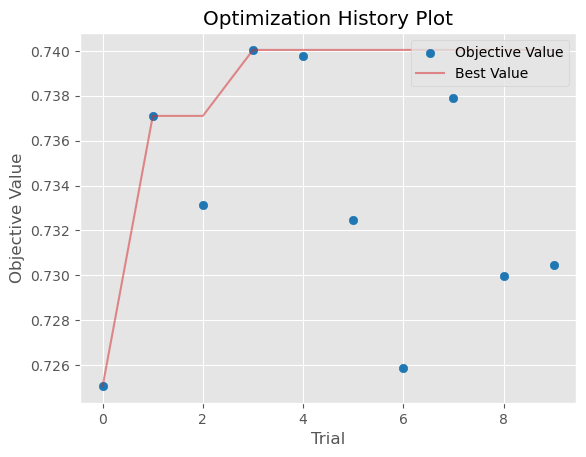

In [65]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.legend(loc="upper right")
plt.savefig("optimization_history_study_1.png")

# Make final tuning

In [66]:
y_train = train_data["outcome"]
X_train = train_data.drop(columns=["outcome"])

d_full_train = xgboost.dask.DaskQuantileDMatrix(None, X_train, y_train)

In [67]:
final_model = xgboost.dask.train(
    None,
    {'objective':'multi:softmax',
     'num_class':3,
     "eval_metric": "mlogloss",
     "tree_method": "gpu_hist",
     'predictor':'gpu_predictor',
     **study.best_params},
    d_full_train,
    num_boost_round=100
)


[12:26:50] task [xgboost.dask-0]:tcp://127.0.0.1:36611 got new rank 0


# Collect final results

In [69]:
y_test = test_data["outcome"]
X_test = test_data.drop(columns=["outcome"])

d_test = xgboost.dask.DaskQuantileDMatrix(None, X_test, y_test)

In [70]:
predictions = xgboost.dask.predict(None, final_model, X_test)
score = accuracy_score(y_test.astype("float32"), predictions, convert_dtype=True)
score

0.7194719314575195

In [71]:
dump(final_model['booster'], os.path.join(RESOURCES_DIR, 'model_xgboost_dask_cuml_v0.1.joblib'))

['/home/jgsolar/Documentos/SHARED/Projetos Pessoais/multiplatform_classifier/B_resources/d_DASK_CUDA_RAPIDS/model_xgboost_dask_cuml_v0.1.joblib']

In [72]:
client.shutdown()